# AIMs Positions, Populations and MAFs

In [2]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Compare the panels

In [3]:
from components.panel_analyser import PanelAnalyser
from components.panel import Panel


panels = [p for p in Panel.all_panels()
          if "GAL" in p.label and "from" not in p.label]

analyser = PanelAnalyser()
count_comparison = analyser.compare_panel_lengths(panels)
ancestry_comparison = analyser.compare_AIMs_ancestry(panels)
lsbl_comparison = analyser.compare_LSBL(panels)

print("== Counts\n")
print(count_comparison)
print()

print("== Counts per ancestry\n")
print(ancestry_comparison)
print()

print("== LSBL cumsum per ancestry\n")
print(lsbl_comparison)


== Counts

              AIMs count  Ratio
Panel                          
GAL_Faltantes        262   0.59
GAL_Completo         445   1.00
GAL_Affy             179   0.40

== Counts per ancestry

      GAL_Affy                  GAL_Completo                  GAL_Faltantes  \
    AIMs count Panel Percentage   AIMs count Panel Percentage    AIMs count   
AFR         62              35%          115              26%            53   
EUR         71              40%          202              45%           131   
NAM         47              26%          129              29%            82   

                      
    Panel Percentage  
AFR              20%  
EUR              50%  
NAM              31%  

== LSBL cumsum per ancestry

            GAL_Affy          GAL_Completo          GAL_Faltantes         
           LSBL(Fst) LSBL(In)    LSBL(Fst) LSBL(In)     LSBL(Fst) LSBL(In)
population                                                                
AFR             39.6     23.7         

En GAL_Affy observamos un aumento de la proporción de AIMs africanos respecto de los europeos, mientras que la proporción de AIMs americanos sigue igual. Esto podría tener por consecuencia, a primera vista, una sobreestimación del componente africano al usar GAL_Affy. No obstante, debe calcularse el LSBL acumulado de los SNPs de cada grupo y comparar *ese* valor.

Los AIMs que quedan en GAL_Affy siguen balanceados en cuanto a LSBL para determinar los componentes EUR y NAM. EL valor de LSBL queda relativamente más alto que en GAL_Completo, por lo que debemos estar atentos a posibles diferencias en resultado entre GAL_Affy y GAL_Completo que afecten específicamente al componente ancestral africano --en particular, que lo sobreestimen.

Sin embargo, esto no parece ser un problema en nuestros resultados, al menos para las muestras de 1000 Genomas utilizadas. La comparación de proporción de ancestría africana estimada para las diferentes poblaciones parece mantenerse igual entre ambos paneles, a pesar de esa reducción diferencial de AIMs. Con todo, este _caveat_ quedará para futuros usos de GAL_Affy.

/home/juan/repos/tesina/panels/genome.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  centromers["chromosome"] = [i.replace("CEN", "") for i in centromers.index]


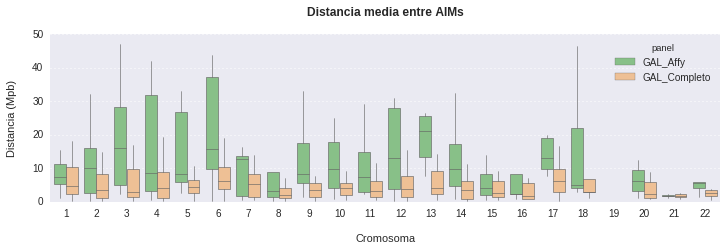

In [4]:
from plotters.snp_distances import SnpDistances


SnpDistances().snp_distances_comparison_boxplot(["GAL_Completo", "GAL_Affy"])

## Comparar Galanter de PLoS / dbSNP / ...

In [5]:
# galanter_remapped = pd.read_csv("/home/juan/tesina/files/galanter.GRCh38.p6.bed", sep="\t",
#                                names=['chr', 'position', 'pos_to', 'id'], comment="#", skiprows=3,
#                                usecols=['chr', 'position', 'pos_to', 'id'])

# # The online remapping generated weird chromosomes
# weird_chromosomes = galanter_remapped["chr"].str.contains("_")
# galanter_remapped.drop(galanter_remapped[weird_chromosomes].index, inplace=True)

# galanter_remapped['chr'] = galanter_remapped['chr'].str.replace("chr", "").astype(int)
# galanter_remapped.drop_duplicates("id", keep="last", inplace=True)
# galanter_remapped.set_index('id', inplace=True)

# galanter_plos = galanter[['chr', 'position']]

# import re

# galanter_dbSNP = pd.read_csv("/home/juan/tesina/files/galanter_rsIDs_dbSNP",
#                              names=['id', 'source', 'chr', 'pos', 'pos_to'], skiprows=1).set_index('id')
# take_these_out = galanter_dbSNP.chr.str.contains('HSCHR')
# galanter_dbSNP = galanter_dbSNP[~take_these_out]
# galanter_dbSNP['chr'] = galanter_dbSNP['chr'].astype(int)
# galanter_dbSNP = galanter_dbSNP.drop_duplicates()

# galanter.index.difference(galanter_remapped.index)

# print(galanter.index.difference(galanter_remapped.index))
# print(galanter_remapped.index.difference(galanter.index))

Debería usar las posiciones de el build `GRCh38.p6` en `galanter_remapped`, pero no están todas puede ser? Chequear

## Generate CONTROL PANELS of random SNPs

- Extract the **same amount * factor** of SNPs per chromosome as Galanter has,
  with some min space between them.
- The SNPs to extract should all be present in LAT-1


The script to generate the SNPs lists is `./scripts/generate_control_panels.py`

With the generated SNP lists per chromosome, we need to extract those variants
from the 1000 Genomes `*.vcf` files, using PLINK.

The script for this is `/home/juan/tesina/1000 ... /create_control_panels.sh`

In [6]:
# # I think this is not needed anymore:
# galanter.groupby("chr").size().to_csv("data/chr_SNP_count_in_galanter")

## Plot the distribution of AIMs per chromosome

* Chromosome lengths were taken from:

[Assembly Statistics for GRCh38.p6 Release date: December 23, 2015](http://www.ncbi.nlm.nih.gov/projects/genome/assembly/grc/human/data/)

* Centromere ranges were taken from the FTP server: 

ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA_000001405.21_GRCh38.p6/GCA_000001405.21_GRCh38.p6_assembly_structure/genomic_regions_definitions.txt

El archivo `galanter.bed` con las posiciones de los AIMs reportadas por Galanter *et al.* correspondía al genoma de referencia `GRCh37.p5`. La conversión al build `GRCh38.p6` fue realizada online con la herramienta de *remapping* provista por NCBI Genome Tools, de modo que fueran coherentes con la información sobre longitud total de los cromosomas y rango de los centrómeros.

http://www.ncbi.nlm.nih.gov/genome/tools/remap

In [7]:
# galanter["pos"] = galanter_remapped["position"]

/home/juan/repos/tesina/panels/genome.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  centromers["chromosome"] = [i.replace("CEN", "") for i in centromers.index]
/home/juan/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


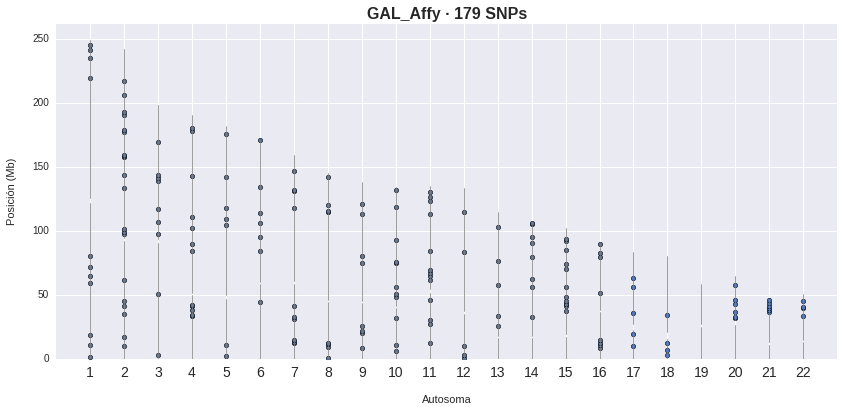

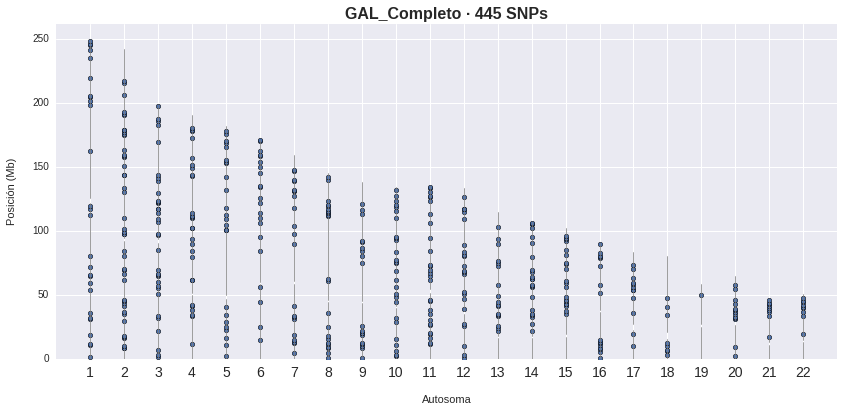

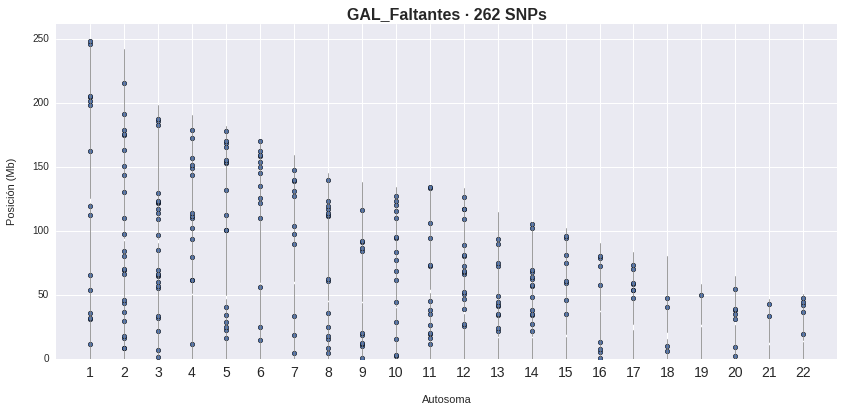

In [8]:
import matplotlib.pyplot as plt

from components.panel import Panel
from plotters.snp_distances import SnpDistances


plotter = SnpDistances()
for panel in Panel.all_panels():
    plotter.chromosomes_with_SNPs_plot(panel)

## Descarga de data de 1000Genomes

In [9]:
# %load /home/juan/tesina/1000genomes/ftp_download_1000_genomes.py

In [10]:
# % run extract_SNPs_from_vcf_chromosomes.py

# commands = extract_SNPs_from_vcf(galanter.index.values)

# ^ One time only run, to extract the SNPs out of the big files of 1000genomes:
# run_commands(commands, "/home/juan/tesina/1000genomes")

## Compute MAF by Population (1000 Genomes data)

I use both `plink` and `pandas` for this computation. `pandas` to make the `.fam` files
with either population or subpopulation names in the family field. `plink` to
compute the frequencies using each of the `.fam` files.

In [11]:
# # This is used to generate different .fam files (with population and superpopulation data)
# # so that plink can generate frequencies relative to those groups.

# basedir = "/home/juan/tesina/1000Genomes_data/galanter_beds/"
# fam_file_fields = ["fam", "sample", "father", "mother", "sex", "phenotype"]

# for panel_name in panel_labels:

#     # Read original .fam with no populations info
#     fn = basedir + "{}.fam".format(panel_name)
#     nofam = pd.read_csv(fn, engine="python", sep="\s*", names=fam_file_fields,
#                         index_col="sample")

#     # Write the populations info to a new .tfam
#     df = nofam.copy()
#     df["fam"] = df_1000G_samples["population"]
#     df.reset_index(inplace=True)
#     df = df[fam_file_fields]
#     fn = basedir + "{}.populations.fam".format(panel_name)
#     df.to_csv(fn, sep="\t", header=False, index=False)

#     # Write the superpopulations info to a new .tfam
#     df = nofam.copy()
#     df["fam"] = df_1000G_samples["superpopulation"]
#     df.reset_index(inplace=True)
#     df = df[fam_file_fields]
#     fn = basedir + "{}.superpopulations.fam".format(panel_name)
#     df.to_csv(fn, sep="\t", header=False, index=False)

After the previous cell (`.fam` files generation), plink was run to compute the frequencies per population and generate the `.frq.strat` files.

Check the bash script `/home/juan/tesina/1000Genomes/galanter_beds/2_compute_freqs.sh`

# Breve descripción de las muestras usadas de 1000 Genomas

In [12]:
from sources.thousand_genomes import ThousandGenomes
from components.dataset import Dataset
from pandas import Series

samples = ThousandGenomes().all_samples
mask = samples["population"].isin(Dataset.used_populations())
used_samples = samples[mask]
used_samples.pivot_table(index=["superpopulation", "population"],
                         columns="gender", margins=True, aggfunc=len).applymap(int)

gender                       female  male   All
super_population population                    
AFR              LWK             55    44    99
                 YRI             56    52   108
AMR              CLM             51    43    94
                 MXL             32    32    64
                 PEL             44    41    85
                 PUR             50    54   104
EAS              CHB             57    46   103
                 CHS             53    52   105
EUR              GBR             45    46    91
                 IBS             53    54   107
SAS              GIH             47    56   103
All                             543   520  1063

## Comparar los MAFs por población y panel

In [13]:
from sources.thousand_genomes import ThousandGenomes
from components.panel import Panel

def minidescribe(df):
    mafs = ThousandGenomes().mafs()
    df = df.join(mafs["population"]["GAL_Completo"]).loc[:, "ACB":"YRI"]
    df = df.describe().loc[["mean", "std"]].T
    df = df.applymap(lambda x: round(x, 2))
    df["mean ± std"] = df["mean"].astype(str) + " ± " + df["std"].astype(str)
    return df

galanter_summary = minidescribe(Panel("GAL_Completo").extra_info)
present_summary = minidescribe(Panel("GAL_Affy").extra_info)

# This uses Galanter-provided MAFs!
maf_mean_comparison = galanter_summary.join(present_summary, rsuffix="_")
maf_mean_comparison["Difference"] = abs(maf_mean_comparison["mean"] - maf_mean_comparison["mean_"])
maf_mean_comparison.drop(["mean", "std", "mean_", "std_"], axis=1, inplace=True)
maf_mean_comparison.columns = ["GAL_Completo", "GAL_Affy", "Difference"]

print("Comparación usando los MAFs en muestras de 1000 Genomas")
maf_mean_comparison.ix[Dataset.used_populations()]

Comparación usando los MAFs en muestras de 1000 Genomas


/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1588: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1590: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


,GAL_Completo,GAL_Affy,Difference
PEL,0.21 ± 0.11,0.19 ± 0.12,0.02
MXL,0.33 ± 0.13,0.31 ± 0.14,0.02
CLM,0.34 ± 0.11,0.32 ± 0.12,0.02
PUR,0.32 ± 0.1,0.3 ± 0.1,0.02
IBS,0.22 ± 0.12,0.19 ± 0.11,0.03
GBR,0.22 ± 0.12,0.2 ± 0.12,0.02
YRI,0.11 ± 0.1,0.11 ± 0.09,0.00
LWK,0.12 ± 0.1,0.13 ± 0.09,0.01
CHB,0.27 ± 0.14,0.26 ± 0.15,0.01
CHS,0.26 ± 0.14,0.26 ± 0.15,0.00


^ Entre ambos paneles no hay ninguna población cuyos MAFs (promediados para todos los AIMs!) cambien demasiado. Es un comienzo.

/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1588: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1590: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


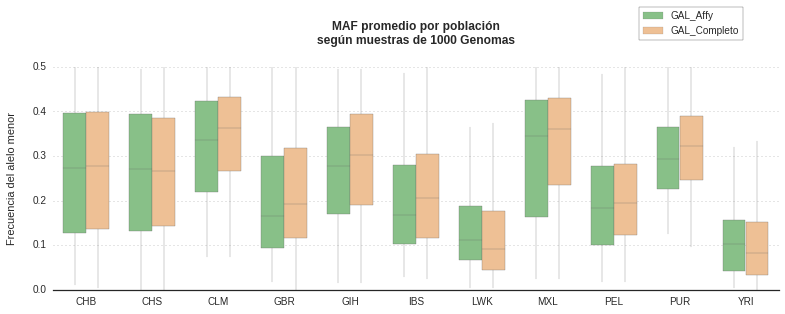

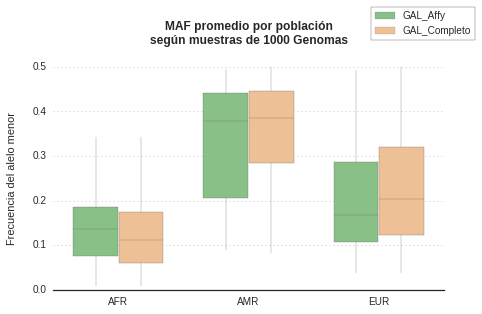

In [14]:
import seaborn as sns

from plotters.maf_plotter import MAFPlotter


sns.set_context("notebook")
sns.set_style("white")


MAFPlotter().MAF_comparison_boxplot()

^ Should mean continental MAFs be similar between 1000 Genomes samples and the ones in Galanter csv? They are not.

# La series de SNPs contra frecuencias en cada continente

/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1588: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1590: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/juan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,window=10).mean()


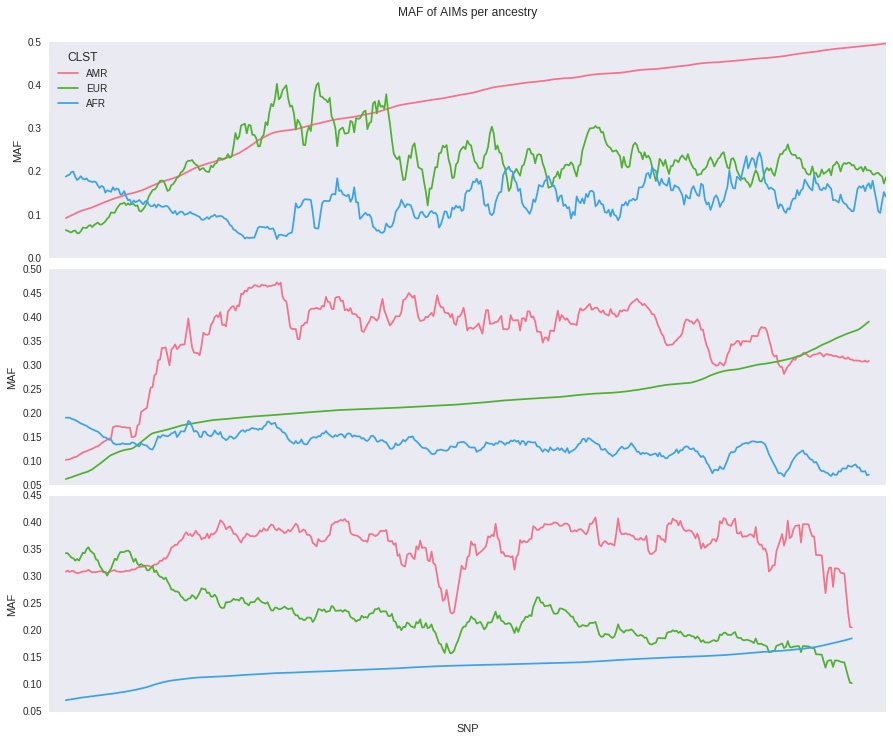

In [15]:
import pandas as pd

from helpers.plot_helpers import hide_spines_and_ticks, population_colors
from sources.thousand_genomes import ThousandGenomes
from os.path import expanduser


sns.set_style("dark")

continents = ["AMR", "EUR", "AFR"]
df = ThousandGenomes.mafs()["superpopulation"]["GAL_Completo"][continents]

fig = plt.figure(figsize=(15, 12))
ax = None

for i, continent in enumerate(continents):
    ax = fig.add_subplot(3, 1, i+1)
    df = df.sort_values(by=continent)
    df = pd.rolling_mean(df, window=10)
    colors = population_colors().values()
    ax = df.plot(ax=ax, rot=90, color=sns.color_palette("husl", 3))
    ax.set_xticklabels([])
    ax.set_ylabel("MAF")
    ax.xaxis.set_label("")
    hide_spines_and_ticks(ax, spines="all")
    if i+1 != 1:
        ax.legend_.set_visible(False)
    else:
        ax.set_title("MAF of AIMs per ancestry", y=1.1)

plt.subplots_adjust(left=None, right=None, hspace=0.05)
plt.savefig(expanduser("~/tesina/charts/panel_analyses/MAF_series"),
            dpi=400, bbox_inches="tight")
plt.show()

Se podría decir que las series EUR y AFR se correlacionan negativamente... No mucho más. AMR no dice nada.